<a href="https://colab.research.google.com/github/jasonericr/dissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### INSTALL/LOAD NECESSARY LIBRARIES

In [ ]:
# for working with Excel files
!pip install openpyxl

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
# Trend analysis
!pip install pymannkendall

In [ ]:
!pip install ruptures
import ruptures as rpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00


In [ ]:
# import needed libraries
from google.colab import files
import io
import json
import numpy as np
import pandas as pd
from datetime import date as dt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
from openpyxl import load_workbook
from statsmodels.tsa.stattools import acf
from itertools import product
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import xgboost as xgb
import shap
# import mann kendall test for trend hypothesis testing
import pymannkendall as mk

#Update pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

#### DATA INGESTION

In [ ]:
# financial statement data files to upload
uploaded = files.upload()

Saving aal-financials (1).xlsx to aal-financials (1).xlsx
Saving aapl-financials (1).xlsx to aapl-financials (1).xlsx
Saving abt-financials (1).xlsx to abt-financials (1).xlsx
Saving adbe-financials (1).xlsx to adbe-financials (1).xlsx
Saving adm-financials (1).xlsx to adm-financials (1).xlsx
Saving aee-financials (1).xlsx to aee-financials (1).xlsx
Saving aep-financials (1).xlsx to aep-financials (1).xlsx
Saving ait-financials (1).xlsx to ait-financials (1).xlsx
Saving al-financials (1).xlsx to al-financials (1).xlsx
Saving amat-financials (1).xlsx to amat-financials (1).xlsx
Saving amd-financials (1).xlsx to amd-financials (1).xlsx
Saving amgn-financials (1).xlsx to amgn-financials (1).xlsx
Saving amp-financials (1).xlsx to amp-financials (1).xlsx
Saving amt-financials (1).xlsx to amt-financials (1).xlsx
Saving amzn-financials (1).xlsx to amzn-financials (1).xlsx
Saving apd-financials (1).xlsx to apd-financials (1).xlsx
Saving as-financials (1).xlsx to as-financials (1).xlsx
Saving a

In [ ]:
# create an empty dataframe
df = pd.DataFrame()

# loop through all fin statement excel files and load to df
for file in uploaded.keys():
  # create temp df to load each individual stock
  temp_df = pd.DataFrame()

  try:
    # upload file from google docs and transpose; upload by each FS type
    xlsx_file = io.BytesIO(uploaded.get(file))
    income_stmt = pd.read_excel(xlsx_file, 'Income-Quarterly', header=None)
    income_stmt_t = income_stmt.set_index([0]).T.reset_index()
    # need EPS diluted from TTM to calc share price; rename Quarterly EPS Diluted to avoid naming conflict
    income_stmt_t.rename(columns={'EPS (Diluted)': 'EPS (Diluted) Qrtly'}, inplace=True)

    # only pull in TTM EPS diluted to calc share price
    income_stmt_ttm = pd.read_excel(xlsx_file, 'Income-TTM',  header=None)
    income_stmt_ttm_t = income_stmt_ttm.set_index([0]).T.reset_index()
    income_stmt_ttm_t = income_stmt_ttm_t[['index', 'EPS (Diluted)']]
    income_stmt_ttm_t.rename(columns={'index':'index_v'}, inplace=True)

    bs_stmt = pd.read_excel(xlsx_file, 'Balance-Sheet-Quarterly', header=None)
    bs_stmt_t = bs_stmt.set_index([0]).T.reset_index()
    bs_stmt_t.rename(columns={'index':'index_x', 'Date':'date_x'}, inplace=True)

    cf_stmt = pd.read_excel(xlsx_file, 'Cash-Flow-Quarterly', header=None)
    cf_stmt_t = cf_stmt.set_index([0]).T.reset_index()
    cf_stmt_t.rename(columns={'index':'index_y', 'Date':'date_y'}, inplace=True)

    ratios_stmt = pd.read_excel(xlsx_file, 'Ratios-Quarterly', header=None)
    ratios_stmt_t = ratios_stmt.set_index([0]).T.reset_index()
    ratios_stmt_t.rename(columns={'index':'index_z', 'Date':'date_z'}, inplace=True)


    # concatenate all 4 different fin statements into temp df and add field for ticker symbol
    temp_df = pd.concat([income_stmt_t, income_stmt_ttm_t, bs_stmt_t, cf_stmt_t, ratios_stmt_t], axis=1)
    temp_df = temp_df.drop(columns=['index_v', 'index_x', 'index_y', 'index_z', 'date_x', 'date_y', 'date_z'])
    temp_df['ticker_symbol'] = file.replace('-financials (1).xlsx', '')


    if df.empty:
      df = temp_df
    else:
      df = pd.concat([df, temp_df], axis=0)

  except:
    continue

#### DATA CLEANUP

In [ ]:
# change object features to numerical; exclude report date and ticker symbol
obj_cls_list = list(df.select_dtypes('object').columns)[1:-1]
#for col in obj_cls_list:
#  df[col] = np.where(df[col]==None, np.nan, df[col])
for col in obj_cls_list:
  df[col] = df[col].astype('float')

In [ ]:
# Create a copy of dataframe containing all stocks w/ their financials
df_copy = df.copy()

# print # of records before changes
display(print(f'# of records before clean-up: {df_copy.shape[0]}.'))

# calculate stock price at each time interval from Book Value Per Share and Price-to-Book Ratio
df_copy['share_price'] = df_copy['Book Value Per Share'] * df_copy['PB Ratio']
df_copy['share_price'] = df_copy['share_price'].apply(lambda x: np.round(x, 2))

# remove records where there is no share price; allows for the period-over-period stock price change since this is our output
df_no_null_stock_price = df_copy[~df_copy['share_price'].isnull()]
# Group by stock symbol and remove rows with no share price
df_no_null_stock_price = df_no_null_stock_price[df_no_null_stock_price['share_price']!=0]

# number of records before and after removing dataframes with null price values
display(print(f'% of records removed as they have null share prices: {(df_copy.shape[0]-df_no_null_stock_price.shape[0])/df_copy.shape[0]*100:0.1f}%'))

# Calculate price percentage change
# Sort by ticker symbol and date (in descending order) so most recent dates for each stock are top of dataframe and % change calc can be performed
df_no_null_stock_price = df_no_null_stock_price.sort_values(['ticker_symbol', 'Date'], ascending=[True, True])

# change Data to date data type
df_no_null_stock_price['Date'] = pd.to_datetime(df_no_null_stock_price['Date'])
# limit stocks to those with financial data betwee 1996 and 2024
df_no_null_stock_price = df_no_null_stock_price[(df_no_null_stock_price['Date']>'1995-12-31') & (df_no_null_stock_price['Date']<'2025-01-01')]

# calculate stock price % change period over period for each ticker symbol
df_no_null_stock_price['share_prct_chg'] = df_no_null_stock_price.groupby(['ticker_symbol'], as_index=False)['share_price'].pct_change()
# remove any records with no stock share % change; these would be the earliest records for each stock since they have nothing to comp over
df_no_null_stock_chng = df_no_null_stock_price[~df_no_null_stock_price['share_prct_chg'].isnull()]

# reset index for each stock ticker based on reporting date
# drop original index field
df_no_null_stock_chng = df_no_null_stock_chng.drop(columns=['index'])
# sort df by ticker symbol and date
df_no_null_stock_chng = (
    df_no_null_stock_chng.sort_values(['ticker_symbol', 'Date'],
                                      ascending=[True, False]))
# reset index based on reporting date grouped by ticker symbol;
# adds an time-series index for each stock so the most recent period starts
# at 1 and each subsequent period gets incremented by 1.  Since stocks have varying history and reporting peiods, this helps with period alignment across
# all stock tickers.
df_no_null_stock_chng['index'] = df_no_null_stock_chng.groupby(['ticker_symbol'], as_index=False).cumcount()+1

# remove OM stock
df_no_null_stock_chng = df_no_null_stock_chng[df_no_null_stock_chng['ticker_symbol']!='om']

# calc % record loss after
display(print(f'% record loss after dropping stocks with null % change in share price: {(df_no_null_stock_price.shape[0]-df_no_null_stock_chng.shape[0])/df_no_null_stock_price.shape[0]*100:0.1f}%'))
display(print(f'# of records after clean-up: {df_no_null_stock_chng.shape[0]}.'))
df_no_null_stock_chng.head(10)

# of records before clean-up: 21421.


None

% of records removed as they have null share prices: 5.0%


None

% record loss after dropping stocks with null % change in share price: 1.0%


None

# of records after clean-up: 18847.


None

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,EBIT,EBIT Margin,EPS (Diluted),Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol,share_price,share_prct_chg,index
3,2024-12-31,13660.0,0.04578,5868.0,7792.0,4585.0,0.0,6658.0,2073.0,1134.0,470.0,-131.0,795.0,205.0,590.0,0.0,590.0,30.05263,657.130996,NaN,0.00549,0.90,0.85,16.00000,-0.435,0.0,NaN,0.57042,0.08302,0.04319,-0.02094,0.25786,3510.0,0.25695,2245.0,1265.0,0.09261,1.24,1536.0,6180.0,7716.0,-0.09095,2006.0,2638.0,794.0,13154.0,38460.0,0.0,6135.0,4034.0,48629.0,61783.0,2455.0,0.0,6414.0,24295.0,15426.0,31130.0,41465.0,10335.0,65760.0,37544.0,-0.07670,-6843.0,-4565.0,-3977.0,-29828.0,NaN,NaN,-11141.0,-6.052,590.0,2245.0,92.0,-2529.0,398.0,NaN,-684.0,0.0,1464.0,86.0,866.0,0.0,0.0,-1351.0,56.0,-1295.0,-31.0,-286.0,NaN,-0.02094,-0.435,11453.793260,0.27553,41281.793260,13.539,0.211,-2.880,5.861716,2.875670,-9.440282,0.400165,0.541,NaN,NaN,NaN,0.056689,0.0,0.0,-0.005494,-0.005494,aal,17.43,0.550712,1
4,2024-09-30,13647.0,0.01224,6291.0,7356.0,4566.0,0.0,7267.0,2701.0,89.0,480.0,-135.0,-256.0,-107.0,-149.0,0.0,-149.0,NaN,656.703913,NaN,0.00511,-0.23,-0.23,NaN,0.082,0.0,NaN,0.53902,0.00652,-0.01092,0.00396,NaN,224.0,0.01641,0.0,224.0,0.01641,0.35,1586.0,7638.0,9224.0,-0.19840,1820.0,2582.0,830.0,14456.0,38555.0,0.0,6137.0,4380.0,49072.0,63528.0,2623.0,0.0,6557.0,25532.0,16352.0,32616.0,42850.0,10234.0,68382.0,39173.0,-0.04931,-7433.0,-4835.0,-4854.0,-29949.0,NaN,NaN,-11076.0,-7.391,-149.0,0.0,0.0,426.0,277.0,3.77586,-223.0,0.0,297.0,-16.0,58.0,0.0,0.0,-137.0,-5.0,-142.0,193.0,54.0,NaN,0.00396,0.082,7381.351982,-0.11807,37330.351982,26.841,0.138,-1.521,129.497403,3.304097,-8.070251,0.432555,0.566,NaN,NaN,NaN,0.042274,0.0,0.0,-0.005114,-0.005114,aal,11.24,-0.007944,2
5,2024-06-30,14334.0,0.01985,6427.0,7907.0,4409.0,0.0,6523.0,2114.0,1384.0,486.0,-130.0,1028.0,311.0,717.0,0.0,717.0,-0.46413,656.090344,NaN,0.00494,1.09,1.01,-0.46277,1.265,0.0,NaN,0.55163,0.09655,0.05002,0.05790,0.30253,1514.0,0.10562,0.0,1514.0,0.10562,-0.25,1480.0,7841.0,9321.0,-0.28547,2067.0,2575.0,832.0,14795.0,38917.0,0.0,6138.0,427

#### EDA

In [ ]:
# Ticker symbols and their amount of missing share prices
# no rows should be missing share prices
df_no_null_stock_chng.groupby(['ticker_symbol']).agg(null_vals=('share_price', lambda x:x.isnull().sum()))

,null_vals
ticker_symbol,
aal,0
aapl,0
abt,0
adbe,0
adm,0
aee,0
aep,0
ait,0
al,0


In [ ]:
# check the maximum reporting date for each stock ticker
# all are within Q4 2024; each stock will report on slightly different timeframes; not all will be Dec 2024
df_no_null_stock_chng.groupby(['ticker_symbol']).agg(max_dates=('Date', np.max))


/tmp/ipython-input-583532194.py:3: FutureWarning: The provided callable <function max at 0x797aa5b677e0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_no_null_stock_chng.groupby(['ticker_symbol']).agg(max_dates=('Date', np.max))


,max_dates
ticker_symbol,
aal,2024-12-31
aapl,2024-12-28
abt,2024-12-31
adbe,2024-11-29
adm,2024-12-31
aee,2024-12-31
aep,2024-12-31
ait,2024-12-31
al,2024-12-31


##### Check NULL values for Predictor Features

In [ ]:
# check % missing values by feature
(df_no_null_stock_chng.isnull().sum()/df_no_null_stock_chng.shape[0]*100).sort_values(ascending=False)

,0
0,
Return on Assets (ROA),100.000000
Return on Equity (ROE),100.000000
Asset Turnover,100.000000
Net Cash (Debt) Growth,84.708442
Dividend Growth,38.817849
Free Cash Flow Growth,35.369024
Net Cash Per Share,28.413010
Shares Outstanding (Diluted),28.413010
Other Investing Activities,26.837162


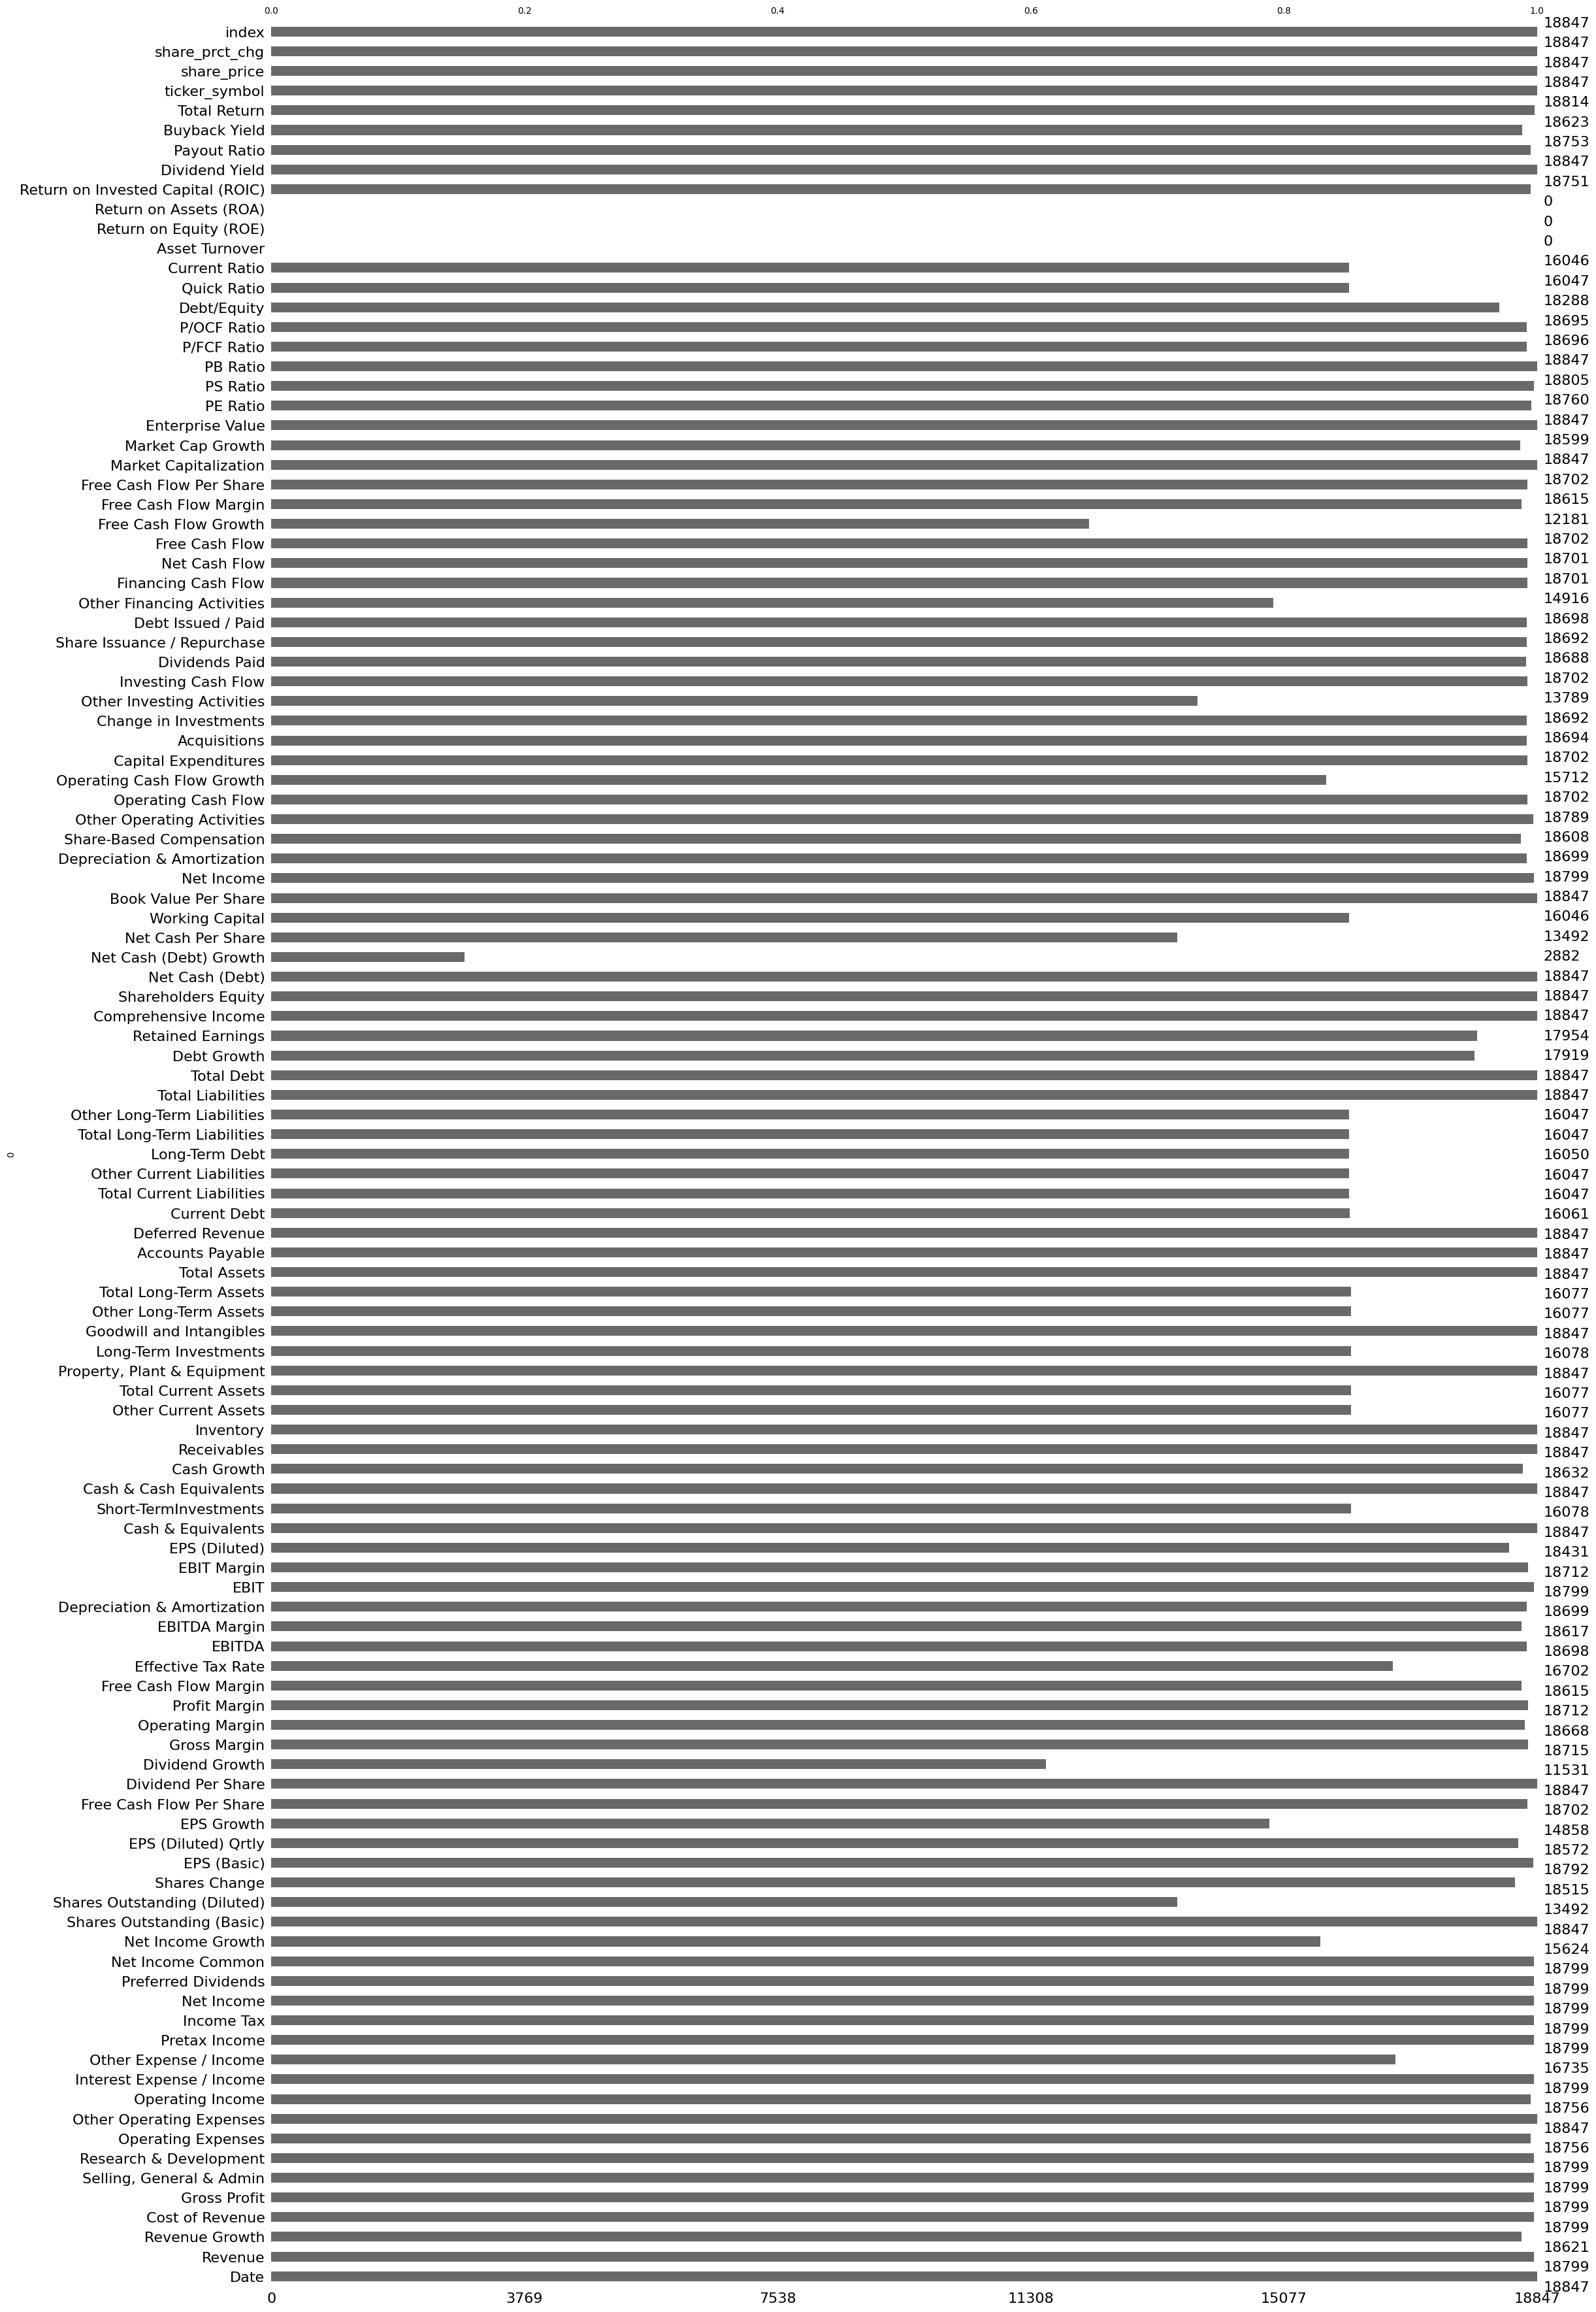

In [ ]:
# Visualize missing values
# missing feature variables values are purposeful as they represent true absences of values
msno.bar(df_no_null_stock_chng)
plt.show()

In [ ]:
# Verify that the share price % change field (target variable) has no NULL values; need all share prices
assert df_no_null_stock_chng[df_no_null_stock_chng['share_prct_chg'].isnull()].shape[0] == 0, 'Not all share prices % changes values are zero. Check the forward-fill.'

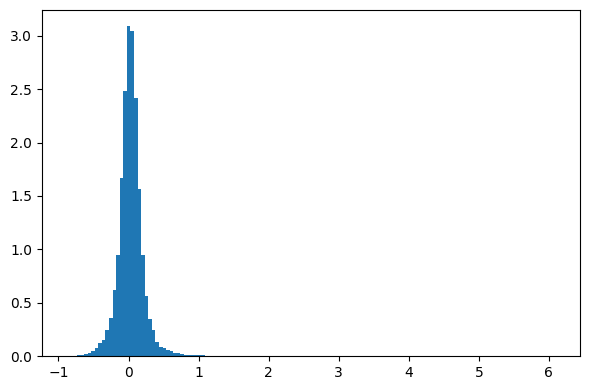

In [ ]:
# Explore distribution of Share Price % Change
plt.figure(figsize=(6,4))
plt.hist(x=df_no_null_stock_chng['share_prct_chg'],
         histtype='stepfilled',
         bins=int(np.sqrt(df_no_null_stock_chng.shape[0])),
         density=True)
plt.tight_layout()
plt.show()

#### ADDITIONAL FEATURE ENGINEERING

In [ ]:

# # remove Date field as no longer needed given Index provides chronological variable
df_no_date = df_no_null_stock_chng.drop(columns=['Date'])

# # Drop columns with no data
no_missing_data_mask = ((df_no_date.isnull().sum()/df_no_date.shape[0]) != 100.00)

# # Remove fields missing all data
df_filtered = df_no_date[list(df_no_date.columns[no_missing_data_mask])]
df_filtered.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,Depreciation & Amortization,EBIT,EBIT Margin,EPS (Diluted),Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Net Income,Depreciation & Amortization,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Margin,Free Cash Flow Per Share,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol,share_price,share_prct_chg,index
3,13660.0,0.04578,5868.0,7792.0,4585.0,0.0,6658.0,2073.0,1134.0,470.0,-131.0,795.0,205.0,590.0,590.0,0.0,590.0,30.05263,657.130996,NaN,0.00549,0.90,0.85,16.00000,-0.435,-0.435,0.0,NaN,0.57042,0.08302,0.04319,-0.02094,-0.02094,0.25786,3510.0,0.25695,2245.0,2245.0,1265.0,0.09261,1.24,1536.0,6180.0,7716.0,-0.09095,2006.0,2638.0,794.0,13154.0,38460.0,0.0,6135.0,4034.0,48629.0,61783.0,2455.0,0.0,6414.0,24295.0,15426.0,31130.0,41465.0,10335.0,65760.0,37544.0,-0.07670,-6843.0,-4565.0,-3977.0,-29828.0,NaN,NaN,-11141.0,-6.052,590.0,590.0,2245.0,2245.0,92.0,-2529.0,398.0,NaN,-684.0,0.0,1464.0,86.0,866.0,0.0,0.0,-1351.0,56.0,-1295.0,-31.0,-286.0,NaN,-0.02094,-0.02094,-0.435,-0.435,11453.793260,0.27553,41281.793260,13.539,0.211,-2.880,5.861716,2.875670,-9.440282,0.400165,0.541,NaN,NaN,NaN,0.056689,0.0,0.0,-0.005494,-0.005494,aal,17.43,0.550712,1
4,13647.0,0.01224,6291.0,7356.0,4566.0,0.0,7267.0,2701.0,89.0,480.0,-135.0,-256.0,-107.0,-149.0,-149.0,0.0,-149.0,NaN,656.703913,NaN,0.00511,-0.23,-0.23,NaN,0.082,0.082,0.0,NaN,0.53902,0.00652,-0.01092,0.00396,0.00396,NaN,224.0,0.01641,0.0,0.0,224.0,0.01641,0.35,1586.0,7638.0,9224.0,-0.19840,1820.0,2582.0,830.0,14456.0,38555.0,0.0,6137.0,4380.0,49072.0,63528.0,2623.0,0.0,6557.0,25532.0,16352.0,32616.0,42850.0,10234.0,68382.0,39173.0,-0.04931,-7433.0,-4835.0,-4854.0,-29949.0,NaN,NaN,-11076.0,-7.391,-149.0,-149.0,0.0,0.0,0.0,426.0,277.0,3.77586,-223.0,0.0,297.0,-16.0,58.0,0.0,0.0,-137.0,-5.0,-142.0,193.0,54.0,NaN,0.00396,0.00396,0.082,0.082,7381.351982,-0.11807,37330.351982,26.841,0.138,-1.521,129.497403,3.304097,-8.070251,0.432555,0.566,NaN,NaN,NaN,0.042274,0.0,0.0,-0.005114,-0.005114,aal,11.24,-0.007944,2
5,14334.0,0.01985,6427.0,7907.0,4409.0,0.0,6523.0,2114.0,1384.0,486.0,-130.0,1028.0,311.0

In [ ]:
# Remove columns that have 100% null values
df_filtered = df_no_date.dropna(axis=1, how='all')

In [ ]:
# Check to see there are no columns missing 100% data
(df_filtered.isnull().sum()/df_filtered.shape[0]*100).sort_values(ascending=False)

,0
0,
Net Cash (Debt) Growth,84.708442
Dividend Growth,38.817849
Free Cash Flow Growth,35.369024
Shares Outstanding (Diluted),28.413010
Net Cash Per Share,28.413010
Other Investing Activities,26.837162
EPS Growth,21.165172
Other Financing Activities,20.857431
Net Income Growth,17.100865


In [ ]:
# clean/format column headers
df_filtered.columns = [col.lower() for col in df_filtered.columns]
df_filtered.columns = [col.replace(" ", "_") for col in df_filtered.columns]
df_filtered.columns = [col.replace(",", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("&", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("(", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace(")", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("/", "") for col in df_filtered.columns]

df_filtered_copy = df_filtered.loc[:,~df_filtered.columns.duplicated()].copy()
df_filtered_copy.head()

,revenue,revenue_growth,cost_of_revenue,gross_profit,selling_general__admin,research__development,operating_expenses,other_operating_expenses,operating_income,interest_expense__income,other_expense__income,pretax_income,income_tax,net_income,preferred_dividends,net_income_common,net_income_growth,shares_outstanding_basic,shares_outstanding_diluted,shares_change,eps_basic,eps_diluted_qrtly,eps_growth,free_cash_flow_per_share,dividend_per_share,dividend_growth,gross_margin,operating_margin,profit_margin,free_cash_flow_margin,effective_tax_rate,ebitda,ebitda_margin,depreciation__amortization,ebit,ebit_margin,eps_diluted,cash__equivalents,short-terminvestments,cash__cash_equivalents,cash_growth,receivables,inventory,other_current_assets,total_current_assets,property_plant__equipment,long-term_investments,goodwill_and_intangibles,other_long-term_assets,total_long-term_assets,total_assets,accounts_payable,deferred_revenue,current_debt,total_current_liabilities,other_current_liabilities,long-term_debt,total_long-term_liabilities,other_long-term_liabilities,total_liabilities,total_debt,debt_growth,retained_earnings,comprehensive_income,shareholders_equity,net_cash_debt,net_cash_debt_growth,net_cash_per_share,working_capital,book_value_per_share,share-based_compensation,other_operating_activities,operating_cash_flow,operating_cash_flow_growth,capital_expenditures,acquisitions,change_in_investments,other_investing_activities,investing_cash_flow,dividends_paid,share_issuance__repurchase,debt_issued__paid,other_financing_activities,financing_cash_flow,net_cash_flow,free_cash_flow,free_cash_flow_growth,market_capitalization,market_cap_growth,enterprise_value,pe_ratio,ps_ratio,pb_ratio,pfcf_ratio,pocf_ratio,debtequity,quick_ratio,current_ratio,return_on_invested_capital_roic,dividend_yield,payout_ratio,buyback_yield,total_return,ticker_symbol,share_price,share_prct_chg,index
3,13660.0,0.04578,5868.0,7792.0,4585.0,0.0,6658.0,2073.0,1134.0,470.0,-131.0,795.0,205.0,590.0,0.0,590.0,30.05263,657.130996,NaN,0.00549,0.90,0.85,16.00000,-0.435,0.0,NaN,0.57042,0.08302,0.04319,-0.02094,0.25786,3510.0,0.25695,2245.0,1265.0,0.09261,1.24,1536.0,6180.0,7716.0,-0.09095,2006.0,2638.0,794.0,13154.0,38460.0,0.0,6135.0,4034.0,48629.0,61783.0,2455.0,0.0,6414.0,24295.0,15426.0,31130.0,41465.0,10335.0,65760.0,37544.0,-0.07670,-6843.0,-4565.0,-3977.0,-29828.0,NaN,NaN,-11141.0,-6.052,92.0,-2529.0,398.0,NaN,-684.0,0.0,1464.0,86.0,866.0,0.0,0.0,-1351.0,56.0,-1295.0,-31.0,-286.0,NaN,11453.793260,0.27553,41281.793260,13.539,0.211,-2.880,5.861716,2.875670,-9.440282,0.400165,0.541,0.056689,0.0,0.0,-0.005494,-0.005494,aal,17.43,0.550712,1
4,13647.0,0.01224,6291.0,7356.0,4566.0,0.0,7267.0,2701.0,89.0,480.0,-135.0,-256.0,-107.0,-149.0,0.0,-149.0,NaN,656.703913,NaN,0.00511,-0.23,-0.23,NaN,0.082,0.0,NaN,0.53902,0.00652,-0.01092,0.00396,NaN,224.0,0.01641,0.0,224.0,0.01641,0.35,1586.0,7638.0,9224.0,-0.19840,1820.0,2582.0,830.0,14456.0,38555.0,0.0,6137.0,4380.0,49072.0,63528.0,2623.0,0.0,6557.0,25532.0,16352.0,32616.0,42850.0,10234.0,68382.0,39173.0,-0.04931,-7433.0,-4835.0,-4854.0,-29949.0,NaN,NaN,-11076.0,-7.391,0.0,426.0,277.0,3.77586,-223.0,0.0,297.0,-16.0,58.0,0.0,0.0,-137.0,-5.0,-142.0,193.0,54.0,NaN,7381.351982,-0.11807,37330.351982,26.841,0.138,-1.521,129.497403,3.304097,-8.070251,0.432555,0.566,0.042274,0.0,0.0,-0.005114,-0.005114,aal,11.24,-0.007944,2
5,14334.0,0.01985,6427.0,7907.0,4409.0,0.0,6523.0,2114.0,1384.0,486.0,-130.0,1028.0,311.0,717.0,0.0,717.0,-0.46413,656.090344,NaN,0.00494,1.09,1.01,-0.46277,1.265,0.0,NaN,0.55163,0.09655,0.05002,0.05790,0.30253,1514.0,0.10562,0.0,1514.0,0.10562,-0.25,1480.0,7841.0,9321.0,-0.28547,2067.0,2575.0,832.0,14795.0,38917.0,0.0,6138.0,4275.0,49330.0,64125.0,3016.0,0.0,5329.0,24610.0,16265.0,34118.0,44261.0,10143.0,68871.0,39447.0,-0.07364,-7284.0,-4858.0,-4746.0,-30126.0,NaN,NaN,-9815.0,-7.234,0.0,411.0,1128.0,-0.36018,-298.0,0.0,-75.0,-3.0,-376.0,0.0,0.0,-684.0,-31.0,-715.0,37.0,830.0,-0.31234,7433.503598,-0.36533,37559.503598,-6

In [ ]:
df_filtered_copy.groupby(['index']).agg(total_periods=('index', np.size)).reset_index()

,index,total_periods
0,1,186
1,2,186
2,3,185
3,4,184
4,5,182
5,6,182
6,7,182
7,8,181
8,9,181
9,10,181


In [ ]:
# count of time periods for each stock
df_filtered_copy.groupby(['ticker_symbol']).agg(total_periods=('index', np.size)).reset_index()

,ticker_symbol,total_periods
0,aal,44
1,aapl,115
2,abt,115
3,adbe,115
4,adm,99
5,aee,115
6,aep,115
7,ait,115
8,al,54
9,amat,112


In [ ]:
df_filtered_copy.head()

,revenue,revenue_growth,cost_of_revenue,gross_profit,selling_general__admin,research__development,operating_expenses,other_operating_expenses,operating_income,interest_expense__income,other_expense__income,pretax_income,income_tax,net_income,preferred_dividends,net_income_common,net_income_growth,shares_outstanding_basic,shares_outstanding_diluted,shares_change,eps_basic,eps_diluted_qrtly,eps_growth,free_cash_flow_per_share,dividend_per_share,dividend_growth,gross_margin,operating_margin,profit_margin,free_cash_flow_margin,effective_tax_rate,ebitda,ebitda_margin,depreciation__amortization,ebit,ebit_margin,eps_diluted,cash__equivalents,short-terminvestments,cash__cash_equivalents,cash_growth,receivables,inventory,other_current_assets,total_current_assets,property_plant__equipment,long-term_investments,goodwill_and_intangibles,other_long-term_assets,total_long-term_assets,total_assets,accounts_payable,deferred_revenue,current_debt,total_current_liabilities,other_current_liabilities,long-term_debt,total_long-term_liabilities,other_long-term_liabilities,total_liabilities,total_debt,debt_growth,retained_earnings,comprehensive_income,shareholders_equity,net_cash_debt,net_cash_debt_growth,net_cash_per_share,working_capital,book_value_per_share,share-based_compensation,other_operating_activities,operating_cash_flow,operating_cash_flow_growth,capital_expenditures,acquisitions,change_in_investments,other_investing_activities,investing_cash_flow,dividends_paid,share_issuance__repurchase,debt_issued__paid,other_financing_activities,financing_cash_flow,net_cash_flow,free_cash_flow,free_cash_flow_growth,market_capitalization,market_cap_growth,enterprise_value,pe_ratio,ps_ratio,pb_ratio,pfcf_ratio,pocf_ratio,debtequity,quick_ratio,current_ratio,return_on_invested_capital_roic,dividend_yield,payout_ratio,buyback_yield,total_return,ticker_symbol,share_price,share_prct_chg,index
3,13660.0,0.04578,5868.0,7792.0,4585.0,0.0,6658.0,2073.0,1134.0,470.0,-131.0,795.0,205.0,590.0,0.0,590.0,30.05263,657.130996,NaN,0.00549,0.90,0.85,16.00000,-0.435,0.0,NaN,0.57042,0.08302,0.04319,-0.02094,0.25786,3510.0,0.25695,2245.0,1265.0,0.09261,1.24,1536.0,6180.0,7716.0,-0.09095,2006.0,2638.0,794.0,13154.0,38460.0,0.0,6135.0,4034.0,48629.0,61783.0,2455.0,0.0,6414.0,24295.0,15426.0,31130.0,41465.0,10335.0,65760.0,37544.0,-0.07670,-6843.0,-4565.0,-3977.0,-29828.0,NaN,NaN,-11141.0,-6.052,92.0,-2529.0,398.0,NaN,-684.0,0.0,1464.0,86.0,866.0,0.0,0.0,-1351.0,56.0,-1295.0,-31.0,-286.0,NaN,11453.793260,0.27553,41281.793260,13.539,0.211,-2.880,5.861716,2.875670,-9.440282,0.400165,0.541,0.056689,0.0,0.0,-0.005494,-0.005494,aal,17.43,0.550712,1
4,13647.0,0.01224,6291.0,7356.0,4566.0,0.0,7267.0,2701.0,89.0,480.0,-135.0,-256.0,-107.0,-149.0,0.0,-149.0,NaN,656.703913,NaN,0.00511,-0.23,-0.23,NaN,0.082,0.0,NaN,0.53902,0.00652,-0.01092,0.00396,NaN,224.0,0.01641,0.0,224.0,0.01641,0.35,1586.0,7638.0,9224.0,-0.19840,1820.0,2582.0,830.0,14456.0,38555.0,0.0,6137.0,4380.0,49072.0,63528.0,2623.0,0.0,6557.0,25532.0,16352.0,32616.0,42850.0,10234.0,68382.0,39173.0,-0.04931,-7433.0,-4835.0,-4854.0,-29949.0,NaN,NaN,-11076.0,-7.391,0.0,426.0,277.0,3.77586,-223.0,0.0,297.0,-16.0,58.0,0.0,0.0,-137.0,-5.0,-142.0,193.0,54.0,NaN,7381.351982,-0.11807,37330.351982,26.841,0.138,-1.521,129.497403,3.304097,-8.070251,0.432555,0.566,0.042274,0.0,0.0,-0.005114,-0.005114,aal,11.24,-0.007944,2
5,14334.0,0.01985,6427.0,7907.0,4409.0,0.0,6523.0,2114.0,1384.0,486.0,-130.0,1028.0,311.0,717.0,0.0,717.0,-0.46413,656.090344,NaN,0.00494,1.09,1.01,-0.46277,1.265,0.0,NaN,0.55163,0.09655,0.05002,0.05790,0.30253,1514.0,0.10562,0.0,1514.0,0.10562,-0.25,1480.0,7841.0,9321.0,-0.28547,2067.0,2575.0,832.0,14795.0,38917.0,0.0,6138.0,4275.0,49330.0,64125.0,3016.0,0.0,5329.0,24610.0,16265.0,34118.0,44261.0,10143.0,68871.0,39447.0,-0.07364,-7284.0,-4858.0,-4746.0,-30126.0,NaN,NaN,-9815.0,-7.234,0.0,411.0,1128.0,-0.36018,-298.0,0.0,-75.0,-3.0,-376.0,0.0,0.0,-684.0,-31.0,-715.0,37.0,830.0,-0.31234,7433.503598,-0.36533,37559.503598,-6

In [ ]:
# remove any data reported beyond 25 years; only want data from the last 25 years (100 quarters)
df_25_yrs = df_filtered_copy[df_filtered_copy['index']<=100]

#### EXPERIMENT 1: EVALUATE CHANGE IN SHAP VALUES

##### Calculate SHAP Values for Company Financials

In [ ]:
### Build a random forest model for each quarter over 25 years
### for target variable % price change over each quarter creating
### a df of shap values for each variable

all_shap_val_dict = {}
index_list = []
best_score_list = []

# Loop through each quarter for last 25 years (100 quarters)
for i in range(1, int(df_25_yrs['index'].max())+1, 1):

  # test running feature selection on most recent quarter
  df_indexed = df_25_yrs[df_25_yrs['index']==i]

  # change object columns to numeric, coercing errors
  for col in df_indexed.select_dtypes(include='object').columns:
    # Exclude known object columns in order to perform SHAP calcs; other variables with obj dtype should be converted to numeric
      if col not in ['ticker_symbol', 'Date', 'index']:
          df_indexed[col] = pd.to_numeric(df_indexed[col], errors='coerce')

  # Drop columns that are all NaN after coercion (if any)
  df_indexed = df_indexed.dropna(axis=1, how='all')

  # Split data by predictor features and reponse variable, excluding 'ticker_symbol' and other non-predictor columns
  # Ensure 'share_prct_chg', 'share_price', 'index', and 'ticker_symbol' are excluded from X
  # Use errors='ignore' in case a column was already dropped
  X = df_indexed.drop(columns=['ticker_symbol', 'share_prct_chg', 'share_price', 'index'], errors='ignore')
  # share percent change is the target variable
  y = df_indexed.loc[:, 'share_prct_chg']


  # Check if X is empty or has too few samples for cross-validation after dropping NaNs
  if X.empty or X.shape[0] < 2:
      print(f"Skipping period {i} due to no valid data or too few samples for modeling after dropping NaNs.")
      continue

  # Determine the number of splits for cross-validation
  n_splits = min(X.shape[0] - 1, 10) # Ensure cv is at most 10 and at least 1 (if X.shape[0] > 1)

  print(f"Period {i}: X shape = {X.shape}, y shape = {y.shape}, n_splits = {n_splits}")


  # instantiate an XGBoost model; perform Randomized Grid Search to find the optimal hyperparameters
  params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[4, 5, 6, 7, 8], 'eta':np.linspace(0.1, 0.9, 10)}
  # Reduce the number of iterations for RandomizedSearchCV for faster execution during debugging
  xgb_base = RandomizedSearchCV(xgb.XGBRFRegressor(), param_distributions=params, cv=n_splits, scoring='neg_mean_squared_error', n_iter=10, random_state=123 )
  xgb_base.fit(X, y)

  # Get the best estimator and its parameters and score
  best_xgb_model = xgb_base.best_estimator_
  best_params = xgb_base.best_params_
  best_score = xgb_base.best_score_

  # append best estimator, parameters, and score to list to put in df
  best_score_list.append(best_score.item())
  # create index list
  index_list.append(i)


  # calculate SHAP values
  # Re-instantiate the explainer with the best estimator from RandomizedSearchCV
  try:
      explainer = shap.TreeExplainer(best_xgb_model)
      shap_values = explainer.shap_values(X)
  except ValueError as e:
      print(f"ValueError during SHAP calculation for period {i}: {e}")
      # Attempt to use KernelExplainer if TreeExplainer fails due to data/model issues
      try:
          print(f"Attempting KernelExplainer for period {i}...")
          # KernelExplainer requires a background dataset. Using a sample of X.
          # Limit background samples for performance
          # Limit to the records for the samples <= 100 for KernelExplainer
          if X.shape[0] > 100:
              background = shap.maskers.Independent(X, max_samples=100)
          else:
              background = shap.maskers.Independent(X, max_samples=X.shape[0])

          # Limit shap_values calculation samples for performance
          if X.shape[0] > 50:
            shap_values = explainer.shap_values(X.sample(50, random_state=123))
          else:
            shap_values = explainer.shap_values(X)

      except Exception as kernel_e:
          print(f"KernelExplainer also failed for period {i}: {kernel_e}")
          continue # Skip this period if both explainers fail


  # zip shap values to their respective features
  shap_dict = dict(zip(X.columns, np.abs(shap_values).mean(axis=0)))
  shap_df = pd.DataFrame({'features':list(shap_dict.keys()), 'shap_vals':list(shap_dict.values())})

  all_shap_val_dict[i] = shap_df


print("Finished processing all periods.")

Period 1: X shape = (186, 103), y shape = (186,), n_splits = 10
Period 2: X shape = (186, 103), y shape = (186,), n_splits = 10
Period 3: X shape = (185, 103), y shape = (185,), n_splits = 10
Period 4: X shape = (184, 103), y shape = (184,), n_splits = 10
Period 5: X shape = (182, 103), y shape = (182,), n_splits = 10


In [ ]:
all_shap_val_dict[1]

In [ ]:
# create dataframe of best model, score, and parameters
best_model_df = pd.DataFrame({'index':index_list, 'best_score':best_score_list})
best_model_df.head()

In [ ]:
# Display SHAP values for periods that did not fail
for period_index, shap_df in all_shap_val_dict.items():
    print(f"SHAP values for period {period_index}:")
    display(shap_df.head())
    print("-" * 30)

In [ ]:
# create dataframe w/ predictor fields and their respective shap values
all_shap_df = pd.DataFrame()

for i in all_shap_val_dict.keys():
  temp_shap_df = all_shap_val_dict[i]
  temp_shap_df['period_index'] = i

  if all_shap_df.empty:
    all_shap_df = temp_shap_df
  else:
    all_shap_df = pd.concat([all_shap_df, temp_shap_df], axis=0)

all_shap_df.head()

In [ ]:
# Save SHAP values df
all_shap_df.to_csv('/content/drive/MyDrive/data/all_shap_df_.csv', index=False)

In [ ]:
# Load csv of saved shap values
all_shap_df = pd.read_csv('/content/drive/MyDrive/data/all_shap_df_.csv')

##### Evaluate Time-Series Trends in SHAP Values using Mann-Kendall Test

In [ ]:
# run mann kendall hypothesis testing for each predictor feature's
# shap to identify any trend in Time Series

# create a dataframe to hold feature and respective mann kendall p-val and test stat

# create empty lists to hold hypothesis testing metrics
mk_features = []
mk_pvals = []
mk_slopes = []
mk_trends = []


for feature in all_shap_df.features.unique():
  # perform hypo testing on each predictive feature's shap values
  feat_result = mk.original_test(all_shap_df['features']==feature)

  # pull slope, trend, and p-value from each shap
  mk_feat = feature
  mk_features.append(mk_feat)

  mk_slope = feat_result.slope
  mk_slopes.append(mk_slope)

  mk_trend = feat_result.trend
  mk_trends.append(mk_trend)

  mk_pval = feat_result.p
  mk_pvals.append(mk_pval)


mk_output_dict = {'features':mk_features, 'slopes':mk_slopes, 'trends':mk_trends, 'pvals':mk_pvals}
mk_test_df = pd.DataFrame.from_dict(mk_output_dict)

# Check Average standard deviation for each individual variable's shap vals
all_shap_stats_df = all_shap_df.groupby(['features'], as_index=False).agg(shap_feat_avg=('shap_vals', np.mean),
                                                      shap_feat_std=('shap_vals', np.std))
all_shap_stats_df.head()

In [ ]:
##### TEST FOR LINEAR TRENDS

In [ ]:
mk_test_df.trends.value_counts()

In [ ]:
all_shap_df.head()

In [ ]:
all_shap_df.groupby([''])

In [ ]:
# plot top features based off highest absolute shap values
top_n = 10
top_std_shap_feat_df_no_cpgr = top_std_shap_feat_df[top_std_shap_feat_df['features']!='market_cap_growth']
top_std_shap_feat_df_no_cpgr = top_std_shap_feat_df_no_cpgr[top_std_shap_feat_df_no_cpgr['features']!='shares_change']
top_std_shap_feat_df = top_std_shap_feat_df_no_cpgr.sort_values(by='shap_feat_avg', ascending=False).iloc[:top_n+1, :]
top_std_shap_feat_df

In [ ]:
list(top_std_shap_feat_df.features.unique())

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(data=all_shap_stats_df.sort_values(by='shap_feat_avg', ascending=False), x='shap_feat_avg', y='features')
plt.title('Shap Values Averages over Time by Financial Metric')
plt.xlabel('Shap Values')
plt.show()

In [ ]:
# plot top features based off highest absolute shap values
top_n = 5
top_mean_shap_feat_df = all_shap_stats_df.sort_values(by='shap_feat_avg', ascending=False).iloc[:top_n, :]
top_mean_shap_cols_lst = top_mean_shap_feat_df.features.unique().tolist()
shap_top_mean_ts_df = all_shap_df[all_shap_df['features'].isin(top_mean_shap_cols_lst)]
# reverse index as 1 represents the most recent reporting period
shap_top_mean_ts_df['period_index'] = -shap_top_mean_ts_df['period_index']

# plot ts trend for top variables with the highest average Shap values
plt.figure(figsize=(20, 10))
sns.lineplot(data=shap_top_mean_ts_df, x='period_index', y='shap_vals', hue='features')
plt.title('Shap Value for Highest Shap Value Features over Time')
plt.xlabel('time index')
plt.ylabel('Shap Values')
plt.show()

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(data=all_shap_stats_df.sort_values(by='shap_feat_std', ascending=False), x='shap_feat_std', y='features')
plt.title('Shap Values Std Dev over Time by Financial Metric')
plt.xlabel('Shap Values')
plt.show()


In [ ]:
# plot top features based off highest absolute shap values
top_n = 5
top_std_shap_feat_df = all_shap_stats_df.sort_values(by='shap_feat_std', ascending=False).iloc[:top_n, :]
top_std_shap_cols_lst = top_std_shap_feat_df.features.unique().tolist()
shap_top_std_ts_df = all_shap_df[all_shap_df['features'].isin(top_std_shap_cols_lst)]
# reverse index as 1 represents the most recent reporting period
shap_top_std_ts_df['period_index'] = -shap_top_std_ts_df['period_index']

In [ ]:
# plot ts trend for top variables with the highest average Shap values
plt.figure(figsize=(20, 10))
sns.lineplot(data=shap_top_std_ts_df, x='period_index', y='shap_vals', hue='features')
plt.title('Shap Value for Most Volatile Features over Time')
plt.xlabel('time index')
plt.ylabel('Shap Values')
plt.show()


In [ ]:
all_shap_df = all_shap_df.sort_values(by=['period_index'], ascending=False)
all_shap_df.head()